In [1]:
# Setup for Advanced Modeling
"""
Advanced Modeling with SMOTE and XGBoost
========================================
Imporving fraud detection with advanced techniques
"""

import sys
sys.path.append('..')
import os
os.chdir('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Import our modules
from src.data.loader import DataLoader
from src.features.engineer import FeatureEngineer

print("Imports complete")

Imports complete


In [3]:
# Load and Prepare Data
# Load and engineer features
loader = DataLoader()
df = loader.load_data()

engineer = FeatureEngineer()
df_engineered = engineer.fit_transform(df)

# Prepare features and target
X = df_engineered.drop(columns=['Class', 'Time'])
y = df_engineered['Class']

# Split data before applying SMOTE
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"Training set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")
print(f"Fraud in train: {y_train.sum()} ({y_train.mean():.2%})")
print(f"Fraud in test: {y_test.sum()} ({y_test.mean():.2%})")

2025-10-06 02:58:14,084 - INFO - Loading data from data\raw\creditcard.csv


2025-10-06 02:58:16,040 - INFO - Data validation passed!
2025-10-06 02:58:16,043 - INFO - Loaded 284,807 transactions
2025-10-06 02:58:16,045 - INFO - Fraud rate: 0.17%
2025-10-06 02:58:16,048 - INFO - Memory usage: 67.4 MB
2025-10-06 02:58:16,099 - INFO - Fitted on 284807 samples.
2025-10-06 02:58:16,581 - INFO - Created 40 total features (excluding 'Time').


Training set: 227845 samples
Test set: 56962 samples
Fraud in train: 394 (0.17%)
Fraud in test: 98 (0.17%)


In [6]:
# Apply SMOTE to Training Data
from imblearn.over_sampling import SMOTE
from collections import Counter

# Check class distribution before SMOTE
print("Before SMOTE:")
print(f"Class distribution: {Counter(y_train)}")
print(f"Ratio: {Counter(y_train)[0] / Counter(y_train)[1]:.1f}:1\n")

# Apply SMOTE
smote = SMOTE(
    sampling_strategy=0.1, # Make fraud 10% of the dataset (instead of 0.17%)
    random_state=42,
    k_neighbors=5
)

X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print("After SMOTE:")
print(f"Class distribution: {Counter(y_train_balanced)}")
print(f"Ratio: {Counter(y_train_balanced)[0] / Counter(y_train_balanced)[1]:.1f}:1")
print(f"Created {len(X_train_balanced) - len(X_train)} synthetic fraud samples")

Before SMOTE:
Class distribution: Counter({0: 227451, 1: 394})
Ratio: 577.3:1

After SMOTE:
Class distribution: Counter({0: 227451, 1: 22745})
Ratio: 10.0:1
Created 22351 synthetic fraud samples


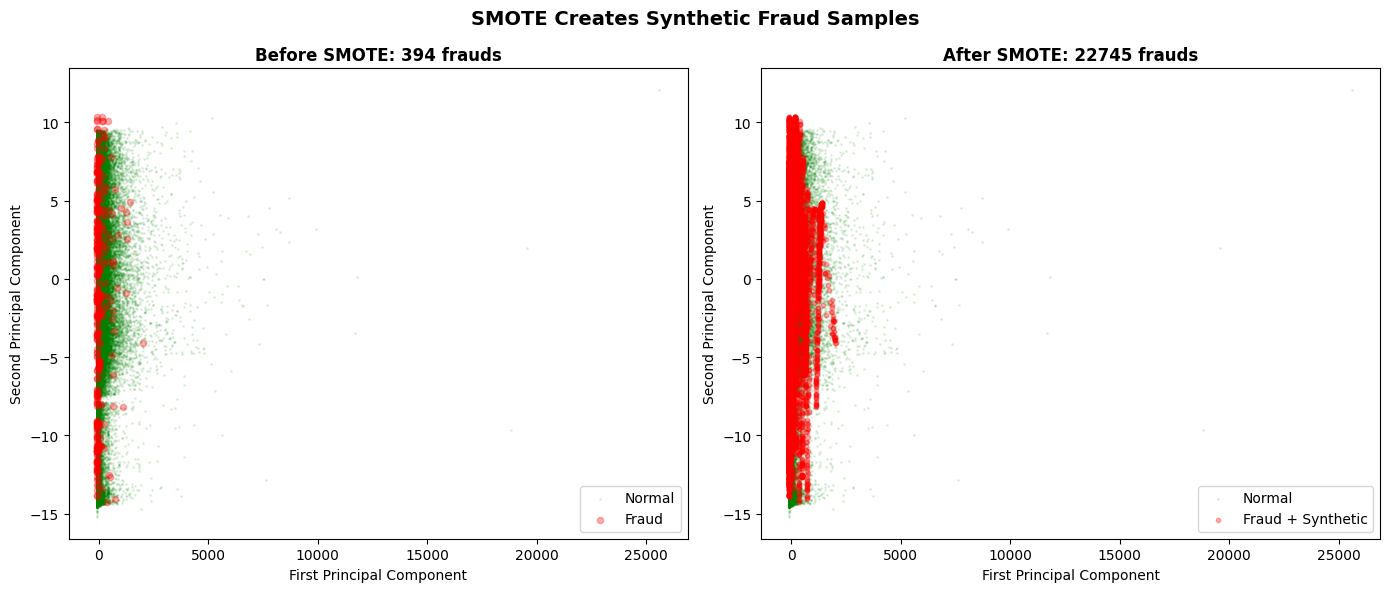

In [13]:
# Visualize SMOTE effect
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)

# Transform original training data
X_train_2d = pca.fit_transform(X_train)

# Transform balanced set
X_train_balanced_2d = pca.transform(X_train_balanced)

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Before SMOTE
ax1 = axes[0]
normal_idx = y_train == 0
fraud_idx = y_train == 1

ax1.scatter(X_train_2d[normal_idx, 0], X_train_2d[normal_idx, 1],
            c='green', alpha=0.1, s=1, label='Normal')
ax1.scatter(X_train_2d[fraud_idx, 0], X_train_2d[fraud_idx, 1],
            c='red', alpha=0.3, s=20, label='Fraud')
ax1.set_title(f'Before SMOTE: {Counter(y_train)[1]} frauds', fontweight='bold')
ax1.set_xlabel('First Principal Component')
ax1.set_ylabel('Second Principal Component')
ax1.legend()

# After SMOTE
ax2 = axes[1]
normal_idx = y_train_balanced == 0
fraud_idx = y_train_balanced == 1

ax2.scatter(X_train_balanced_2d[normal_idx, 0], X_train_balanced_2d[normal_idx, 1],
            c='green', alpha=0.1, s=1, label='Normal')
ax2.scatter(X_train_balanced_2d[fraud_idx, 0], X_train_balanced_2d[fraud_idx, 1],
            c='red', alpha=0.3, s=10, label='Fraud + Synthetic')
ax2.set_title(f'After SMOTE: {Counter(y_train_balanced)[1]} frauds', fontweight='bold')
ax2.set_xlabel('First Principal Component')
ax2.set_ylabel('Second Principal Component')
ax2.legend()

plt.suptitle('SMOTE Creates Synthetic Fraud Samples', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
# Train Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test)

# Train Random Forest classifier on SMOTE data
print("Training Random Forest with SMOTE...")
rf_smote = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=42,
    n_jobs=-1
    # Not using class_weight='balanced' since SMOTE is already balanced
)

rf_smote.fit(X_train_scaled, y_train_balanced)

# Predictions
y_pred_rf = rf_smote.predict(X_test_scaled)
y_pred_rf_proba = rf_smote.predict_proba(X_test_scaled)[:, 1]

# Calculate metrics
print("=" * 50)
print("Random Forest + SMOTE Results:")
print("=" * 50)
print(f"Precision: {precision_score(y_test, y_pred_rf):.3f}")
print(f"Recall: {recall_score(y_test, y_pred_rf):.3f}")
print(f"F1 Score: {f1_score(y_test, y_pred_rf):.3f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_rf_proba):.3f}")

# Confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
print(f"TN: {cm_rf[0,0]:,}  FP: {cm_rf[0,1]:,}")
print(f"FN: {cm_rf[1,0]:,}  TP: {cm_rf[1,1]:,}")

Training Random Forest with SMOTE...
Random Forest + SMOTE Results:
Precision: 0.713
Recall: 0.888
F1 Score: 0.791
ROC-AUC: 0.984
TN: 56,829  FP: 35
FN: 11  TP: 87


In [17]:
# Train XGBoost
import xgboost as xgb

print("\nTraining XGBoost with SMOTE...")

# XGBoost with tuned parameters for fraud detection
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.01,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0,
    reg_lambda=1,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

# Train on SMOTE data
xgb_model.fit(X_train_scaled, y_train_balanced)

# Predictions
y_pred_xgb = xgb_model.predict(X_test_scaled)
y_pred_xgb_proba = xgb_model.predict_proba(X_test_scaled)[:, 1]

# Results
print("="*50)
print("XGBoost + SMOTE Results:")
print("="*50)
print(f"Precision: {precision_score(y_test, y_pred_xgb):.3f}")
print(f"Recall: {recall_score(y_test, y_pred_xgb):.3f}")
print(f"F1 Score: {f1_score(y_test, y_pred_xgb):.3f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_xgb_proba):.3f}")

# Confusion matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
print(f"\nConfusion Matrix:")
print(f"TN: {cm_xgb[0,0]:,}  FP: {cm_xgb[0,1]:,}")
print(f"FN: {cm_xgb[1,0]:,}  TP: {cm_xgb[1,1]:,}")

# Business Impact
print(f"\nBusiness Impact:")
print(f"False alarms: {cm_xgb[0,1]:,}")
print(f"Missed frauds: {cm_xgb[1,0]:,}")
print(f"Ratio: {cm_xgb[0,1]/cm_xgb[1,1]:.2f} false alarms per fraud caught")


Training XGBoost with SMOTE...
XGBoost + SMOTE Results:
Precision: 0.755
Recall: 0.816
F1 Score: 0.784
ROC-AUC: 0.980

Confusion Matrix:
TN: 56,838  FP: 26
FN: 18  TP: 80

Business Impact:
False alarms: 26
Missed frauds: 18
Ratio: 0.33 false alarms per fraud caught
